In [ ]:
import functools
import functorch as ft
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.autograd.forward_ad as fwAD
import torchvision
import tqdm

from statistics import mean 
from torch import nn
from torch.utils.data import DataLoader

# Gradients without Backpropagation

## 1. Description of the method

### Introduction
The paper introduces a new method to compute the gradient of an objective function for optimization that is based on forward mode instead of reverse mode (backpropagation). So, the key idea is to evaluate the gradient in a single forward run of the function eliminating the need for backpropagation. 

### Proposed method
The method proposed by the authors of the paper consists of the following steps: 

1.   Sample a random perturbation vector  $v\sim p(v)$, which has the same size of $f$'s argument $\theta$. In particular, $p(v)$ must have two properties:  the components must be independent from each other, and they must have zero mean and unit variance. 
2.   Simultaneously compute $f(\theta)$ and $\nabla f(\theta) \cdot v$ in a single forward run, without having to compute $\nabla f(\theta)$ at all in the process. 
3. The authors defined the forward gradient as $g (\theta) = (\nabla f(\theta) \cdot v) \cdot v$. They then proved that the forward gradient $g(\theta)$ is an unbiased estimator of the gradient $\nabla f(\theta)$. So, the last step is to compute this value $g (\theta) $ and use it to update the parameters. 

The final algorithm is the following: 

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/final_algorithm.png?raw=true)

### Our implementation
We will now discuss how we implemented the above algorithm, Forward Gradient Descent. 

First of all, we needed to generate the sample perturbation vector $v$, remembering to respect the properties that we discussed in the introduction (the components must be independent from each other, and they must have zero mean and unit variance). Given parameters **params**, we generated the sample perturbation vector as:
```
v = torch.randn_like(params)
```
This implementation respects the properties described above because, from documentation, torch.randn_like "returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean $0$ and variance $1$" [[1.1]](https://pytorch.org/docs/stable/generated/torch.randn_like.html).

In the following step we needed to implement the computation of $f$ and $d$ simultaneously in the forward pass. To do this we applied what we learned from this documentation: [[1.2]](https://pytorch.org/tutorials/intermediate/forward_ad_usage.html). In particular, we applied two distinct techniques for our implementations "Optimization Trajectiories of Test Functions" and "Logistic Regression and Multi-Layer Neural Network". However, both are based on the implementation of dual numbers that allow to compute in forward automatic differentiation the output and its derivative in a single run. 


1.   In our first implementation, we used the method described in the first paragraph of the documentation, "Basic Usage". First of all, it's necessary to include the line:
```
with fwAD.dual_level():
```
From the documentation, "This is to ensure that if the output or intermediate results of this computation are reused in a future forward AD computation, their tangents (which are associated with this computation) won't be confused with tangents from the later computation". At this point, the forward pass is easily computed with the following instructions:
```
dual_input = fwAD.make_dual(params, v)
dual_output = f(dual_input)
f, d = fwAD.unpack_dual(dual_output)
```
This is a straightforward implementation of how to compute $f$ and $d$ in a single forward pass.

2.   In the second experiment, we instead used another approach to compute $f$ and $d$. In particular, we referred to the paragraph "Using the functional API with Modules" of the above linked documentation, where the function **functorch.jvp** is introduced. This approach is indeed more suitable when we need to compute the Jacobian-vector products with respect to the parameters of a nn.Module. Therefore, we first extracted a functional version of the model that can be invoked like a function as follows:
```
f, params = functorch.make_functional(model)
```
Then, still from the documentation, we learned that "Because jvp requires every input to be associated with a tangent, we need to create a new function that, when given the parameters, produces the output", so we proceeded to introduce such a function:
```
def func_params_only(params): 
        return f(params, xb, yb)
```
And, finally, we were able to compute the actual result for $f$ and $d$ as follows:
```
f, d = ft.jvp(func_params_only, (params,), (v,))
```

The last two steps required for the implementation of the FGD algorithm are simply obtaining $g$ as the product of $d$ and $v$, and then use these values to perform the parameters update. The implementation of these two operations is straightforward:
```
g = d * v 
params -= lr * g 
```

The next sections will show in more detail the implementations described earlier. In order to make a comparison, we used in all of our examples both the forward gradient method and the classical backpropagation approach. 

## 2. Implementation 1 - Optimization Trajectories of Test Functions




First, we followed one of the experiments held by the authors of the paper. From the paper: "First we look at test functions for optimization, and compare
the behavior of forward gradient and backpropagation in the $\mathbb{R}^2$ space where we can plot and follow optimization trajectories". The functions used for this purpose are:


*   the Beale function: $f(x, y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$
*   and the Rosenbrock function: $f(x,y)=(a-x)^2+b(y-x^2)^2$, where $a=1, b=100$



### Beale Function

In [ ]:
# This is the direct implementation of the Beale Function defined above
def beale(params):
  x = params[0]
  y = params[1]
  return (
      (torch.tensor([1.5]) - x + x * y) ** 2 + 
      (torch.tensor([2.25]) - x + x * y ** 2) ** 2 + 
      (torch.tensor([2.625]) - x + x * y ** 3) ** 2
  )

In [ ]:
# Initialization of parameters
epochs = 1000 
lr = 0.01 # Learning rate

# Lists to store results
hist_beale_fgd = [] # List used to store the results of the optimization process at each epoch
time_beale_fgd = [] # List used to store the time at each epoch
hist_beale_sgd = [] # List used to store the results of the optimization process at each epoch
time_beale_sgd = [] # List used to store the time at each epoch

#### Forward Gradient Implementation

In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

for epoch in range(epochs):
  v = torch.randn_like(params) # Sample perturbation vector
  
  # Computation of both output and derivative
  with fwAD.dual_level():
    dual_input = fwAD.make_dual(params, v)
    dual_output = beale(dual_input)
    f, d = fwAD.unpack_dual(dual_output)

  g = d * v # Forward gradient
  params -= lr * g # Parameter update

  # Updating the lists 
  hist_beale_fgd.append(f.item()) 
  t = time.time()
  time_beale_fgd.append(t - t_0)

#### Backpropagation




In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

opt = torch.optim.SGD([params], lr=lr) # As optimizer we choose SGD and pass to it the parameters and the learning rate

for epoch in range(epochs):  
  params.requires_grad_(True)
  opt.zero_grad() # We zero the gradients
  f = beale(params) # Computation of the output
  f.backward() # Compute the gradient
  opt.step() # Perform optimization step automatically over the parameters

  # Updating the lists
  hist_beale_sgd.append(f.item()) 
  t = time.time()
  time_beale_sgd.append(t - t_0)

#### Results plotted

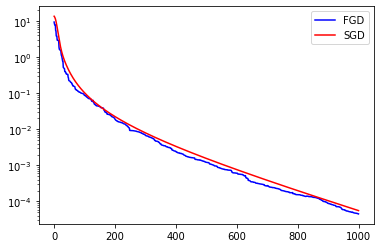

In [ ]:
# Results Beale wrt Epochs
x = np.array(np.arange(0, epochs, 1))
y_f = hist_beale_fgd
y_s = hist_beale_sgd

fig, ax = plt.subplots()
ax.plot(x, y_f, 'b')
ax.plot(x, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

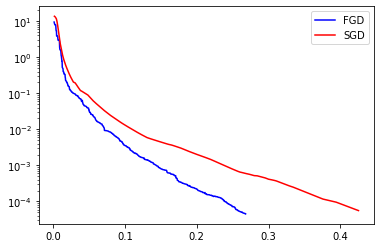

In [ ]:
# Results Beale wrt Time
x_f = time_beale_fgd
x_s = time_beale_sgd
y_f = hist_beale_fgd
y_s = hist_beale_sgd

fig, ax = plt.subplots()
ax.plot(x_f, y_f, 'b')
ax.plot(x_s, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

### Rosenbrock Function

In [ ]:
# This is the direct implementation of the Rosenbrock Function defined above
def rosenbrock(params):
  x = params[0]
  y = params[1]
  return (torch.tensor([1]) - x) ** 2 + 100 * (y - x ** 2) ** 2

In [ ]:
# Initialization of parameters
epochs = 25000 
lr = 0.0005 # Learning rate

# Lists to store results
hist_rosenbrock_fgd = [] # List used to store the results of the optimization process at each epoch
time_rosenbrock_fgd = [] # List used to store the time at each epoch
hist_rosenbrock_sgd = [] # List used to store the results of the optimization process at each epoch
time_rosenbrock_sgd = [] # List used to store the time at each epoch

#### Forward Gradient Implementation

In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

for epoch in range(epochs):
  v = torch.randn_like(params) # Sample perturbation vector
  
  # Computation of both output and derivative
  with fwAD.dual_level():
    dual_input = fwAD.make_dual(params, v)
    dual_output = rosenbrock(dual_input)
    f, d = fwAD.unpack_dual(dual_output)

  g = d * v # Forward gradient
  params -= lr * g # Parameter update

  # Updating the lists 
  hist_rosenbrock_fgd.append(f.item()) 
  t = time.time()
  time_rosenbrock_fgd.append(t - t_0)

#### Backpropagation


In [ ]:
params = torch.rand(2) # Initialization of the parameters that we aim to optimize
t_0 = time.time() # Initial time

opt = torch.optim.SGD([params], lr=lr) # As optimizer we choose SGD and pass to it the parameters and the learning rate

for epoch in range(epochs):  
  params.requires_grad_(True)
  opt.zero_grad() # We zero the gradients
  f = rosenbrock(params) # Computation of the output
  f.backward() # Compute the gradient
  opt.step() # Perform optimization step automatically over the parameters

  # Updating the lists
  hist_rosenbrock_sgd.append(f.item()) 
  t = time.time()
  time_rosenbrock_sgd.append(t - t_0)

#### Results plotted

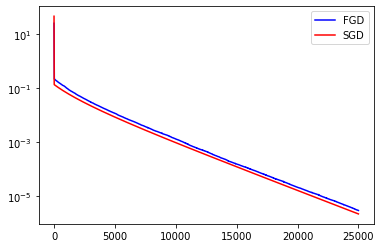

In [ ]:
# Results Rosenbrock wrt Epochs
x = np.array(np.arange(0, epochs, 1))
y_f = hist_rosenbrock_fgd
y_s = hist_rosenbrock_sgd

fig, ax = plt.subplots()
ax.plot(x, y_f, 'b')
ax.plot(x, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

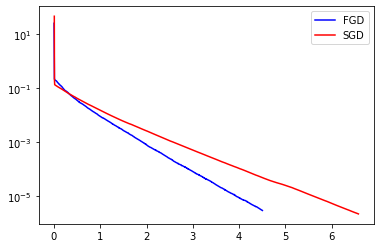

In [ ]:
# Results Rosenbrock wrt Time
x_f = time_rosenbrock_fgd
x_s = time_rosenbrock_sgd
y_f = hist_rosenbrock_fgd
y_s = hist_rosenbrock_sgd

fig, ax = plt.subplots()
ax.plot(x_f, y_f, 'b')
ax.plot(x_s, y_s, 'r')
ax.set_yscale('log')
ax.legend(['FGD', 'SGD'])

### Results

For this first experiment, we used the same values of the authors of the paper for the following parameters: 

*   Number of iterations (1,000 for Beale function, 25,000 for Rosenbrock function)
*   Learning rate (0.01 for Beale function, 0.0005 for Rosenbrock function)

The results that we obtain are in line with theirs. In general, we notice that the loss behaves similarily both in forward gradient and backpropagation with respect to the number of iterations. However, forward gradient converges to the solution slightly faster per iteration. 

**Beale function:**

These are the results of the loss obtained by the authors with respect to the number of iterations and the time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Beale.png?raw=true)

This is the loss that we obtained with respect to the number of iterations:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Beale_nostra_loss_.png?raw=true)

Instead, here is the loss with respect to the time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Beale_nostra_time_.png?raw=true)

**Rosenbrock function:**

Here are the results of the loss obtained by the authors with respect to the number of iterations and the time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Rosenbrock.png?raw=true)

This is the loss that we obtained with respect to the number of iterations:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Rosenbrock_nostra_loss_.png?raw=true)

Here is the loss with respect to the time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Rosenbrock_nostra_time_.png?raw=true)

Of course, our results in time are slightly worse than those of the authors due to our limited computational resources, however, they confirm that FGD converges faster to a solution with respect to SGD.

## 3. Implementation 2 - Logistic Regression and Multi-Layer Neural Network

Also for our second experiment, we followed those held by the authors of the paper. In particular, we tested the forward gradient method both for logistic regression and on a multi-layer neural network for MNIST digit classification.

### Models

**Logistic Regression:**

In [ ]:
# The forward method includes the computation of the loss. This will be useful during the training
class LRModel(nn.Module):
  def __init__(self):
    super(LRModel, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(28*28, 10)
  
  def forward(self, x, y):
    x = self.flatten(x)
    x = self.linear(x)
    loss = nn.functional.cross_entropy(x, y)
    return loss 

**Multi-Layer Neural Network:**

From the paper, the architecture should have "three fully-connected layers of size 1024, 1024, 10, with ReLU activation after the first two layers". 

In [ ]:
# This is the implementation of the architecture defined above
# The forward method includes the computation of the loss. This will be useful during the training
class MLNNModel(nn.Module):    
    def __init__(self):
      super(MLNNModel, self).__init__()
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(28*28, 1024)
      self.fc2 = nn.Linear(1024, 1024)
      self.fc3 = nn.Linear(1024, 10)

    def forward(self, x, y):
      x = self.flatten(x)
      x = nn.functional.relu(self.fc1(x))
      x = nn.functional.relu(self.fc2(x))
      x = self.fc3(x)
      loss = nn.functional.cross_entropy(x, y)
      return loss

### Dataset

In [ ]:
# Download the dataset applying the transformation

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor() 
])

train_data = torchvision.datasets.MNIST('/content/data', train=True, download=True, transform = transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [ ]:
# Dataloader

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)

In [ ]:
# Now let's define the test data and test loader

test_data = torchvision.datasets.MNIST('/content/data', train=False, download=True, transform = transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Forward Gradient Implementation

In [ ]:
# Run this for training the Logistic Regression
model = LRModel()

In [ ]:
# Run this for training the Multi-Layer Neural Network
model = MLNNModel()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initializations of the parameters
epochs = 22
lr = 2e-4

# Lists to keep track of the values of the loss
history_fgd_train = []
history_fgd_valid= []
time_fgd = []

In [ ]:
# We disable gradient computation to reduce memory consumption since we are not 
# going to use Tensor.backward() (from documentation [3.1])
with torch.no_grad():
  model.to(device)
  model.float()
  model.train() 

  f, params = ft.make_functional(model) #returns a functional version of the model so that can be invoked like a function
  t_0 = time.time() # Initial time

  batch_train_loss = [] # List to keep track of the train loss at each iteration

  for epoch in range(epochs):
    
    batch_valid_loss = [] # List to keep track of the valid loss at each iteration 
    
    for xb, yb in tqdm.tqdm(train_loader):
      xb, yb = xb.to(device), yb.to(device) # xb are the images, yb the labels

      v = tuple([torch.randn_like(p) for p in params]) #sample perturbation vector

      #Because jvp requires every input to be associated with a tangent, we need to
      #create a new function that, when given the parameters, produces the output (from documentation [1.2])
      def func_params_only(params): 
        return f(params, xb, yb)
      
      # Computation of both output and derivative
      train_loss, d = ft.jvp(func_params_only, (params,), (v,))
      batch_train_loss.append(train_loss.item())

      for j, p in enumerate(params): 
        g = d * v[j] #Forward gradient
        p -= lr * g #Parameter update
      
      # Print the results and update the lists
      t = time.time()
      time_fgd.append(t - t_0)

    # Compute the validation loss
    for xb, yb in test_loader:
      xb, yb = xb.to(device), yb.to(device)
      valid_loss = func_params_only(params)
      batch_valid_loss.append(valid_loss.item())
    
    history_fgd_valid.append(mean(batch_valid_loss)) # Epoch loss
    
    print(f"Epoch [{epoch+1}], Loss: {train_loss.item():.4f}, Valid loss: {valid_loss.item():.4f}")  

history_fgd_train = batch_train_loss # Loss at each iteration

100%|██████████| 938/938 [00:10<00:00, 88.12it/s] 


Epoch [1], Loss: 2.2860, Valid loss: 2.2852


100%|██████████| 938/938 [00:09<00:00, 101.05it/s]


Epoch [2], Loss: 2.2746, Valid loss: 2.2687


100%|██████████| 938/938 [00:08<00:00, 113.55it/s]


Epoch [3], Loss: 2.2609, Valid loss: 2.2501


100%|██████████| 938/938 [00:08<00:00, 114.11it/s]


Epoch [4], Loss: 2.2495, Valid loss: 2.2294


100%|██████████| 938/938 [00:07<00:00, 125.23it/s]


Epoch [5], Loss: 2.2325, Valid loss: 2.2086


100%|██████████| 938/938 [00:08<00:00, 111.22it/s]


Epoch [6], Loss: 2.2199, Valid loss: 2.1913


100%|██████████| 938/938 [00:08<00:00, 113.36it/s]


Epoch [7], Loss: 2.1989, Valid loss: 2.1709


100%|██████████| 938/938 [00:08<00:00, 113.57it/s]


Epoch [8], Loss: 2.1732, Valid loss: 2.1410


100%|██████████| 938/938 [00:07<00:00, 124.55it/s]


Epoch [9], Loss: 2.1490, Valid loss: 2.1131


100%|██████████| 938/938 [00:08<00:00, 116.45it/s]


Epoch [10], Loss: 2.1188, Valid loss: 2.0684


100%|██████████| 938/938 [00:08<00:00, 112.93it/s]


Epoch [11], Loss: 2.0859, Valid loss: 2.0319


100%|██████████| 938/938 [00:08<00:00, 113.57it/s]


Epoch [12], Loss: 2.0498, Valid loss: 1.9872


100%|██████████| 938/938 [00:07<00:00, 123.96it/s]


Epoch [13], Loss: 2.0093, Valid loss: 1.9413


100%|██████████| 938/938 [00:08<00:00, 105.60it/s]


Epoch [14], Loss: 1.9606, Valid loss: 1.8755


100%|██████████| 938/938 [00:08<00:00, 113.21it/s]


Epoch [15], Loss: 1.9096, Valid loss: 1.7929


100%|██████████| 938/938 [00:08<00:00, 113.68it/s]


Epoch [16], Loss: 1.8406, Valid loss: 1.7212


100%|██████████| 938/938 [00:07<00:00, 123.59it/s]


Epoch [17], Loss: 1.7650, Valid loss: 1.6308


100%|██████████| 938/938 [00:08<00:00, 116.27it/s]


Epoch [18], Loss: 1.6812, Valid loss: 1.5371


100%|██████████| 938/938 [00:08<00:00, 114.70it/s]


Epoch [19], Loss: 1.5718, Valid loss: 1.4268


100%|██████████| 938/938 [00:08<00:00, 111.95it/s]


Epoch [20], Loss: 1.4933, Valid loss: 1.3273


100%|██████████| 938/938 [00:07<00:00, 124.70it/s]


Epoch [21], Loss: 1.3981, Valid loss: 1.1795


100%|██████████| 938/938 [00:08<00:00, 112.36it/s]


Epoch [22], Loss: 1.2961, Valid loss: 1.0615


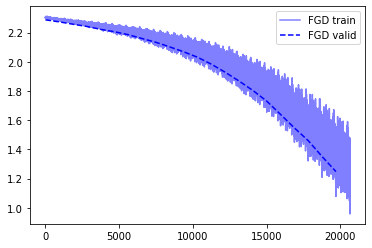

In [ ]:
# Results forward wrt Epochs
x_t = np.array(np.arange(0, 20636, 1))
y_t = history_fgd_train
x_v = np.array(np.arange(0, 22, 1))
y_v = history_fgd_valid

fig, ax = plt.subplots()
ax.plot(x_t, y_t, 'b', alpha=0.5)
ax.plot(x_v*938, y_v, 'b', linestyle='dashed')
ax.legend(['FGD train', 'FGD valid'])

### Backpropagation

In [ ]:
# Run for training the Logistic Regression
model = LRModel()

In [ ]:
# Run for training the Multi-Layer Neural Network
model = MLNNModel()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initializations of the parameters
epochs = 22
lr = 2e-4
opt = torch.optim.SGD(model.parameters(), lr=lr) # As optimizer we choose SGD and pass to it the parameters and the learning rate

# Lists to keep track of the values of the loss
history_sgd_train = []
history_sgd_valid= []
time_sgd = []

In [ ]:
t_0 = time.time() # Initial time
batch_train_loss = [] # List to keep track of the train loss at each iteration

for epoch in range(epochs):

  model.train()
  batch_valid_loss = [] # List to keep track of the valid loss at each iteration
 
  for xb, yb in tqdm.tqdm(train_loader):
    xb,yb = xb.to(device), yb.to(device) # xb are the images, yb the labels
    
    opt.zero_grad() # We zero the gradients 
    train_loss = model(xb,yb) # Computation of the loss
    batch_train_loss.append(train_loss.item())
    train_loss.backward() # Backpropagation
    opt.step() # Updating the parameters

    # Print and update the lists
    t = time.time()
    time_sgd.append(t - t_0)

  # Compute the valid loss
  for xb, yb in test_loader:
    xb,yb = xb.to(device), yb.to(device)
    valid_loss = model(xb, yb)
    batch_valid_loss.append(valid_loss.item())
  
  history_sgd_valid.append(mean(batch_valid_loss)) # Epoch loss
    
  print(f"Epoch [{epoch+1}], Loss: {train_loss.item():.4f}, Valid loss: {valid_loss.item():.4f}")  

history_sgd_train=batch_train_loss # Loss per iteration

100%|██████████| 938/938 [00:08<00:00, 113.19it/s]


Epoch [1], Loss: 2.2955, Valid loss: 2.2827


100%|██████████| 938/938 [00:09<00:00, 100.77it/s]


Epoch [2], Loss: 2.2845, Valid loss: 2.2674


100%|██████████| 938/938 [00:11<00:00, 81.68it/s] 


Epoch [3], Loss: 2.2731, Valid loss: 2.2516


100%|██████████| 938/938 [00:09<00:00, 102.77it/s]


Epoch [4], Loss: 2.2615, Valid loss: 2.2352


100%|██████████| 938/938 [00:07<00:00, 125.31it/s]


Epoch [5], Loss: 2.2491, Valid loss: 2.2178


100%|██████████| 938/938 [00:07<00:00, 121.85it/s]


Epoch [6], Loss: 2.2358, Valid loss: 2.1990


100%|██████████| 938/938 [00:07<00:00, 122.60it/s]


Epoch [7], Loss: 2.2213, Valid loss: 2.1784


100%|██████████| 938/938 [00:07<00:00, 133.86it/s]


Epoch [8], Loss: 2.2054, Valid loss: 2.1560


100%|██████████| 938/938 [00:07<00:00, 125.37it/s]


Epoch [9], Loss: 2.1879, Valid loss: 2.1312


100%|██████████| 938/938 [00:07<00:00, 123.57it/s]


Epoch [10], Loss: 2.1684, Valid loss: 2.1037


100%|██████████| 938/938 [00:06<00:00, 134.27it/s]


Epoch [11], Loss: 2.1467, Valid loss: 2.0731


100%|██████████| 938/938 [00:08<00:00, 114.33it/s]


Epoch [12], Loss: 2.1223, Valid loss: 2.0390


100%|██████████| 938/938 [00:07<00:00, 122.60it/s]


Epoch [13], Loss: 2.0949, Valid loss: 2.0008


100%|██████████| 938/938 [00:08<00:00, 113.99it/s]


Epoch [14], Loss: 2.0640, Valid loss: 1.9581


100%|██████████| 938/938 [00:07<00:00, 133.29it/s]


Epoch [15], Loss: 2.0292, Valid loss: 1.9104


100%|██████████| 938/938 [00:08<00:00, 116.46it/s]


Epoch [16], Loss: 1.9902, Valid loss: 1.8574


100%|██████████| 938/938 [00:07<00:00, 122.69it/s]


Epoch [17], Loss: 1.9465, Valid loss: 1.7991


100%|██████████| 938/938 [00:07<00:00, 130.83it/s]


Epoch [18], Loss: 1.8979, Valid loss: 1.7352


100%|██████████| 938/938 [00:07<00:00, 129.30it/s]


Epoch [19], Loss: 1.8442, Valid loss: 1.6661


100%|██████████| 938/938 [00:07<00:00, 121.35it/s]


Epoch [20], Loss: 1.7856, Valid loss: 1.5925


100%|██████████| 938/938 [00:07<00:00, 121.72it/s]


Epoch [21], Loss: 1.7224, Valid loss: 1.5153


100%|██████████| 938/938 [00:06<00:00, 134.24it/s]


Epoch [22], Loss: 1.6554, Valid loss: 1.4359


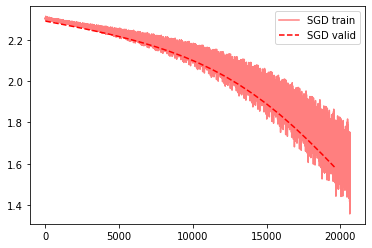

In [ ]:
# Results SGD wrt Epochs
x_t = np.array(np.arange(0, 20636, 1))
y_t = history_sgd_train
x_v = np.array(np.arange(0, 22, 1))
y_v = history_sgd_valid

fig, ax = plt.subplots()
ax.plot(x_t, y_t, 'r', alpha=0.5)
ax.plot(x_v*938, y_v, 'r', linestyle='dashed')
ax.legend(['SGD train', 'SGD valid'])

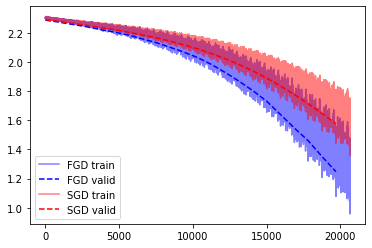

In [ ]:
# Plot the results for both FGD and SGD wrt number of epochs
xt = np.array(np.arange(0, 20636, 1))
xv = np.array(np.arange(0, 22, 1))
yft = history_fgd_train
yfv = history_fgd_valid
yst = history_sgd_train
ysv = history_sgd_valid

fig, ax = plt.subplots()
ax.plot(xt, yft, 'b', alpha=0.5)
ax.plot(xv*938, yfv, 'b', linestyle='dashed')
ax.plot(xt, yst, 'r', alpha=0.5)
ax.plot(xv*938, ysv, 'r', linestyle='dashed')
ax.legend(['FGD train', 'FGD valid', 'SGD train', 'SGD valid'])

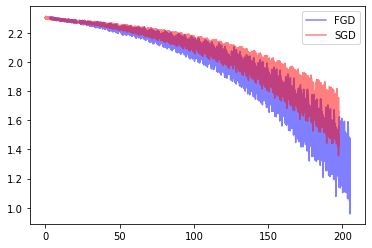

In [ ]:
# Plot the results wrt time in FGD and SGD
x_f = time_fgd
x_s = time_sgd
y_f = history_fgd_train
y_s = history_sgd_train

fig, ax = plt.subplots()
ax.plot(x_f, y_f, 'b', alpha=0.5)
ax.plot(x_s, y_s, 'r', alpha=0.5)
ax.legend(['FGD', 'SGD'])

### Results

Also for this second implementation, we started by attempting the same experiments as the authors of the paper to try and compare the results. 

**Logistic Regression:**

For this implementation, the results provided by the paper are related to a training with a learning rate of $10^{-4}$ for $25,000$ iterations. In our case, we trained it for $30,000$ iterations.

Here are the paper's results for logistic regression:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Logistic_paper.png?raw=true)

These are our results with respect to the number of iterations and the time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/FGD_4_30_Logistic.png?raw=true), iterations

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/FGD_4_30_logistic_time.png?raw=true), seconds

As well as the results shown in the paper, in our experiments it turns out that both techniques have nearly identical behavior in the loss per iteration, however we did not find any improvement in the runtime. 

**Multi-Layer Neural Network:**

In this other experiment, the number of iterations is the same as the previous one, whereas as a learning rate we adopted the same one used by the authors: $2 \times 10^{-4}$. 

These are the results shown in the paper:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/results_mlnn_paper.png?raw=true)

And here are our results, respectively, with respect to the iterations and time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/FGD_4_30_MNN.png?raw=true), iterations

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/FGD_4_30_MNN_time.png?raw=true), seconds

Also in this case our results in terms of iterations are similar to those of the authors. Indeed, forward gradient achieves faster descent in the loss per iteration plot. In terms of time we obtained a very similar running time for both methods, with SGD taking few seconds less to execute. In general, we reached the same conclusions as the authors of the paper: FGD achieves faster descent in the loss per epoch, so it converges faster with respect to the number of epochs.

For what concerns time, we notice that, overall, both methods behave very similarily, with FGD taking slightly more time than SGD to complete the same number of iterations. So, even if the authors presented a solution in which FGD is much faster, we did not notice a speed up in this second implementation. We did notice a speed up in our first experiment. The main difference between the two implementations is given by the fact that in implementation 1 we could directly compute the forward gradient with the function (Beale or Rosenbrock function), and in implementation 2 we had to obtain a functional version of the model, which required us to call some specific functions (such as make_functional, see implementation). Since there is no code available for this paper, we could not make a comparison with the implementation of the authors to understand if there was another, faster way to do the same operations. However, since in our first experiments the time results were actually much better for FGD, we believe that our approach is overall valid. 

## 4. Summary of the main Results

This was our implementation in Pytorch of the method described in the paper "Gradients without Backpropagation". The objective was to show that a new method, consisting of computing the gradient in a single forward pass and completely avoiding backpropagation, could actually be beneficial for learning models. 

In our project, we implemented the proposed algorithm Forward Gradient Descent in three scenarios:

**Optimization Trajectories of Test Functions**: we applied the algorithm to Beale Function and Rosenbrock Function. These are the results for Beale Function with respect to epochs and time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Beale_nostra_loss_.png?raw=true), iterations

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Beale_nostra_time_.png?raw=true), seconds

These are the results for Rosenbrock Function with respect to epochs and time:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Rosenbrock_nostra_loss_.png?raw=true), iterations

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/Rosenbrock_nostra_time_.png?raw=true), seconds

As we can see, FGD and SGD have a pretty similar behavior per iteration. However, it's very interesting to point out that FGD completes the computation in a shorter time. So, if it's true that they have similar results with the same number of iterations, we also have to say that the forward gradient performs the computation in a shorter time.

**Logistic Regression and Multi-Layer Neural Network**: we trained such models with both FGD and SGD. These are their respective results:

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/FGD_4_30_Logistic.png?raw=true), iterations for Logistic Regression

![picture](https://github.com/GiorgiaRistich/Project-Neural-Networks/blob/main/images/FGD_4_30_MNN.png?raw=true), iterations for Multi-Layer NN

The results that we obtained (mostly in the Multi-Layer Neural Network) showed that the forward gradient achieves faster descent in the loss at each iteration. Hence, at the same iteration, the loss achieved by FGD is smaller than the loss achieved by SGD. For what concerns time, we noticed that the execution time for both methods is similar. So, in this second experiment we noticed mainly how the forward gradient has a better behavior per iteration, while having similar results in relation to the runtime.

In conclusion, we applied this new method to different scenarios and, mostly in our first experiment, our results showed the actual improvement that using FGD could bring in the field of Machine Learning. From the paper [4.1]: "We have shown that a typical ML training pipeline can be constructed without backpropagation, using only forward AD, while still being computationally competitive". 

## References

[1.1] https://pytorch.org/docs/stable/generated/torch.randn_like.html

[1.2] https://pytorch.org/tutorials/intermediate/forward_ad_usage.html

[3.1] https://pytorch.org/docs/stable/generated/torch.no_grad.html

[4.1] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. Gradients without Backpropagation (https://arxiv.org/pdf/2202.08587.pdf)